<a href="https://colab.research.google.com/github/samuel06santos/Statistics-LLM/blob/main/BBC_articles_fulltext_and_category_Atividade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Atividade 1 — Z-score e Binomial Distribution Sample distribution and sampling distribution TLC p-value**



---



- **Sistemas de Informação - ICEN - UFPA**
- Docente: Dr. Claudomiro Sales
- Discente: João Samuel Dias Santos - 202211140033


---



In [3]:
#
###
#####
#######
import re
import math
import warnings
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma
from kagglehub import KaggleDatasetAdapter
from sklearn.feature_extraction.text import TfidfVectorizer
#
#
sns.set_palette("husl")
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')



---



# **Parte 1 - Z-score e Binomial Distribution**


# 1. CARREGAMENTO E EXPLORAÇÃO DO DATASET


## **Seção A - Busque um dataset e faça histogramas de duas features para cada classe no dataset, conforme procedimento mostrado em sala. Faça dois conjuntos de histogramas com tamanhos de bins diferentes. Discuta os histogramas do ponto de vista de classificação usando aprendizado de máquina e também discuta os tamanhos dos bins usados.**

**Contextualização do dataset**


O BBC News Classification Dataset é uma coleção de artigos de notícias publicados pela BBC (British Broadcasting Corporation) entre 2004 e 2005. Este dataset foi criado especificamente para fins de pesquisa acadêmica e treinamento de modelos de aprendizado de máquina voltados para classificação automática de textos.

## 1.1. Carregando o dataset através drive

In [4]:
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "yufengdev/bbc-fulltext-and-category",
  "bbc-text.csv",
)

100%|██████████| 1.83M/1.83M [00:00<00:00, 53.4MB/s]

Extracting zip of bbc-text.csv...


## 1.2. Exibindo as dimensões do dataset escolhido (instâncias e colunas)
- O dataset escolhido foi a da BBC (BBC articles fulltext and category), que categoriza em 6 classes cada um dos 2.225 artigos

In [5]:
print(f"Dimensões do dataset: {df.shape}\n")

Dimensões do dataset: (2225, 2)



In [6]:
df.sample(5)

,category,text
2156,sport,dallaglio his own man to the end controversy a...
585,tech,football manager scores big time for the past ...
2169,politics,goldsmith denies war advice claim the attorney...
2117,sport,wales stars need a rest - ruddock wales coach ...
174,politics,mps to debate euthanasia laws mps are prepar...


In [7]:
df['category'].value_counts().sort_index()

,count
category,
business,510
entertainment,386
politics,417
sport,511
tech,401


In [8]:
print(f"Distribuição das classes:")
class_distribution = df['category'].value_counts().sort_index()
for category, count in class_distribution.items():
    percentage = (count / len(df)) * 100
    print(f"{category:15s}: {count:4d} artigos ({percentage:5.2f}%)")


Distribuição das classes:
business       :  510 artigos (22.92%)
entertainment  :  386 artigos (17.35%)
politics       :  417 artigos (18.74%)
sport          :  511 artigos (22.97%)
tech           :  401 artigos (18.02%)


# 2. EXTRAÇÃO DE FEATURES NUMÉRICAS

## 2.1. DEFINIÇÃO DE VOCABULÁRIOS ESPECÍFICOS PARA CADA CATEGORIA

In [9]:
VOCABULARY = {
    'tech': [
        'technology', 'software', 'computer', 'internet', 'digital', 'online',
        'web', 'mobile', 'microsoft', 'apple', 'google', 'chip', 'broadband',
        'users', 'system', 'service', 'net', 'phone', 'pc', 'laptop',
        'security', 'network', 'data', 'email', 'video', 'games', 'console'
    ],
    'sport': [
        'match', 'player', 'team', 'game', 'win', 'goal', 'season', 'club',
        'coach', 'cup', 'championship', 'league', 'football', 'cricket',
        'rugby', 'tennis', 'race', 'victory', 'defeat', 'score', 'points',
        'world', 'title', 'final', 'atletico', 'ball', 'play', 'fans'
    ],
    'politics': [
        'government', 'minister', 'party', 'election', 'political', 'blair',
        'labour', 'policy', 'parliament', 'cabinet', 'vote', 'law', 'council',
        'public', 'plan', 'bill', 'prime', 'conservative', 'liberal', 'union',
        'reform', 'budget', 'tax', 'war', 'iraq', 'military', 'defence'
    ],
    'entertainment': [
        'film', 'music', 'star', 'show', 'album', 'actor', 'award', 'band',
        'singer', 'movie', 'tv', 'television', 'song', 'chart', 'hit',
        'concert', 'theatre', 'performance', 'director', 'hollywood', 'box',
        'nomination', 'best', 'release', 'audience', 'stage', 'comedy'
    ],
    'business': [
        'market', 'company', 'economic', 'economy', 'profit', 'sales', 'growth',
        'shares', 'stock', 'bank', 'financial', 'firms', 'business', 'oil',
        'industry', 'prices', 'trade', 'dollar', 'pound', 'investment',
        'corporate', 'revenue', 'quarter', 'billion', 'million', 'chief'
    ],
}

## 2.2. EXTRAÇÃO DE FEATURES - VOCABULÁRIO ESPECÍFICO

In [10]:
def calculate_vocabulary_score(text, vocabulary_list):
    text_lower = text.lower()
    words = re.findall(r'\b\w+\b', text_lower)
    total_words = len(words)

    if total_words == 0:
        return 0.0

    vocab_count = sum(1 for word in words if word in vocabulary_list)

    return vocab_count / total_words

### 2.2.1. Calculando scores de vocabulário específico

In [11]:
for category, vocab in VOCABULARY.items():
    col_name = f'{category}_vocab_score'
    df[col_name] = df['text'].apply(lambda x: calculate_vocabulary_score(x, vocab))

## 2.3. EXTRAÇÃO DE FEATURES - TF-IDF

### 2.3.1 Criando o vetorizador TF-IDF

In [12]:
tfidf_vectorizer = TfidfVectorizer(
  max_features=1_000,  # Top 1000 palavras
  stop_words='english',
  ngram_range=(1, 2),  # Uni-gramas e bi-gramas
  min_df=5,  # Palavra deve aparecer em pelo menos 5 documentos
  max_df=0.8  # Palavra não pode aparecer em mais de 80% dos docs
)

### 2.3.2 Calculando TF-IDF para todo o corpus

In [13]:
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])
feature_names = tfidf_vectorizer.get_feature_names_out()

In [14]:
print(f"Matriz shape: {tfidf_matrix.shape}")
print(f"Features: {len(feature_names)}")

Matriz shape: (2225, 1000)
Features: 1000


### 2.3.3 Identificando top termos TF-IDF por categoria

In [15]:
top_terms_per_category = {}

for category in df['category'].unique():
    # Obtendo índices dos documentos desta categoria
    category_indices = df[df['category'] == category].index

    # Somando TF-IDF scores para esta categoria
    category_tfidf = tfidf_matrix[category_indices].sum(axis=0).A1

    # Obtendo os top 10 termos
    top_indices = category_tfidf.argsort()[-10:][::-1]
    top_terms = [(feature_names[i], category_tfidf[i]) for i in top_indices]

    top_terms_per_category[category] = top_terms

    print(f"{category.upper()}:")
    for i, (term, score) in enumerate(top_terms[:5], 1):
        print(f"{i}. {term:20s} (score: {score:.2f})")
    print()

TECH:
1. people               (score: 26.84)
2. mobile               (score: 23.07)
3. technology           (score: 22.07)
4. software             (score: 21.07)
5. users                (score: 20.13)

BUSINESS:
1. company              (score: 25.51)
2. growth               (score: 24.66)
3. market               (score: 24.54)
4. mr                   (score: 23.55)
5. economy              (score: 23.46)

SPORT:
1. game                 (score: 29.31)
2. england              (score: 27.80)
3. win                  (score: 26.23)
4. cup                  (score: 23.21)
5. match                (score: 23.01)

ENTERTAINMENT:
1. film                 (score: 51.74)
2. best                 (score: 26.90)
3. music                (score: 21.42)
4. awards               (score: 18.53)
5. band                 (score: 17.91)

POLITICS:
1. mr                   (score: 48.76)
2. labour               (score: 35.86)
3. election             (score: 28.90)
4. blair                (score: 28.82)
5. governmen

### 2.3.4 Selecionando os 2 termos mais discriminativos para features

In [16]:
# Feature 1: Top termo de TECH
tech_top_term = top_terms_per_category['tech'][0][0]

# Feature 2: Top termo de SPORT
sport_top_term = top_terms_per_category['sport'][0][0]

### 2.3.5 Extraindo scores TF-IDF para estes termos

In [17]:
tech_term_idx = np.where(feature_names == tech_top_term)[0][0]
sport_term_idx = np.where(feature_names == sport_top_term)[0][0]

df['tfidf_tech_term'] = tfidf_matrix[:, tech_term_idx].toarray().flatten()
df['tfidf_sport_term'] = tfidf_matrix[:, sport_term_idx].toarray().flatten()

# 3. SELEÇÃO DE FEATURES E ANÁLISE DOS HISTOGRAMAS

### Para a análise dos histogramas, escolhi utilizar duas features:
1. **Proporção de palavras técnicas no texto (`tech_vocab_score`):**
    
    Artigos de TECH terão score alto


2. **Proporção de palavras esportivas no texto (`sport_vocab_score`):**

    Artigos de SPORT terão score alto

In [18]:
# Feature 1: Vocabulário específico de TECH
feature1 = 'tech_vocab_score'
feature1_label = 'Tech Vocabulary Score'

# Feature 2: Vocabulário específico de SPORT
feature2 = 'sport_vocab_score'
feature2_label = 'Sport Vocabulary Score'

In [19]:
df[[feature1, feature2]].describe().round(4)

,tech_vocab_score,sport_vocab_score
count,2225.0000,2225.0000
mean,0.0082,0.0101
std,0.0161,0.0150
min,0.0000,0.0000
25%,0.0000,0.0000
50%,0.0000,0.0035
75%,0.0062,0.0129
max,0.1124,0.0951


# 4. HISTOGRAMAS - CONJUNTO 1 - `BINS = 6` (BINS PEQUENO)


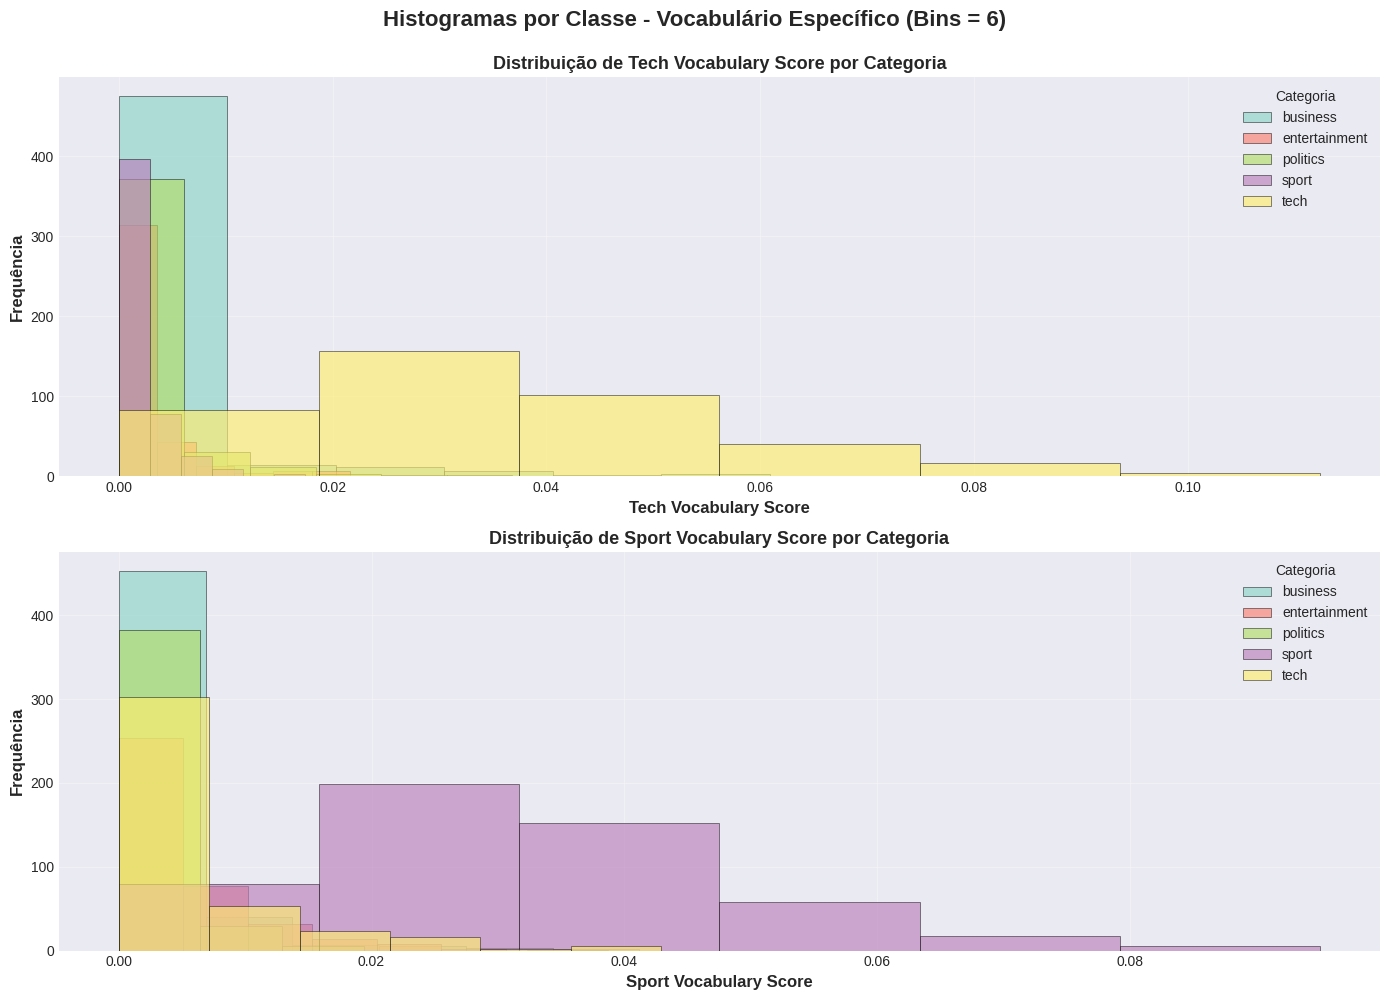

In [20]:
bins1 = 6
categories = sorted(df['category'].unique())
colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))

fig, axes = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle(f'Histogramas por Classe - Vocabulário Específico (Bins = {bins1})', fontsize=16, fontweight='bold', y=0.995)

# Histograma da Feature 1
ax1 = axes[0]
for i, category in enumerate(categories):
  data = df[df['category'] == category][feature1]
  ax1.hist(data, bins=bins1, alpha=0.65, label=category, color=colors[i], edgecolor='black', linewidth=0.5)

ax1.set_xlabel(f'{feature1_label}', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequência', fontsize=12, fontweight='bold')
ax1.set_title(f'Distribuição de {feature1_label} por Categoria', fontsize=13, fontweight='bold')
ax1.legend(title='Categoria', fontsize=10, loc='upper right')
ax1.grid(True, alpha=0.3)

# Histograma da Feature 2
ax2 = axes[1]
for i, category in enumerate(categories):
  data = df[df['category'] == category][feature2]
  ax2.hist(data, bins=bins1, alpha=0.65, label=category, color=colors[i], edgecolor='black', linewidth=0.5)

ax2.set_xlabel(f'{feature2_label}', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequência', fontsize=12, fontweight='bold')
ax2.set_title(f'Distribuição de {feature2_label} por Categoria', fontsize=13, fontweight='bold')
ax2.legend(title='Categoria', fontsize=10, loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# 5. HISTOGRAMAS - CONJUNTO 2 - `BINS = 20` (BINS GRANDE)


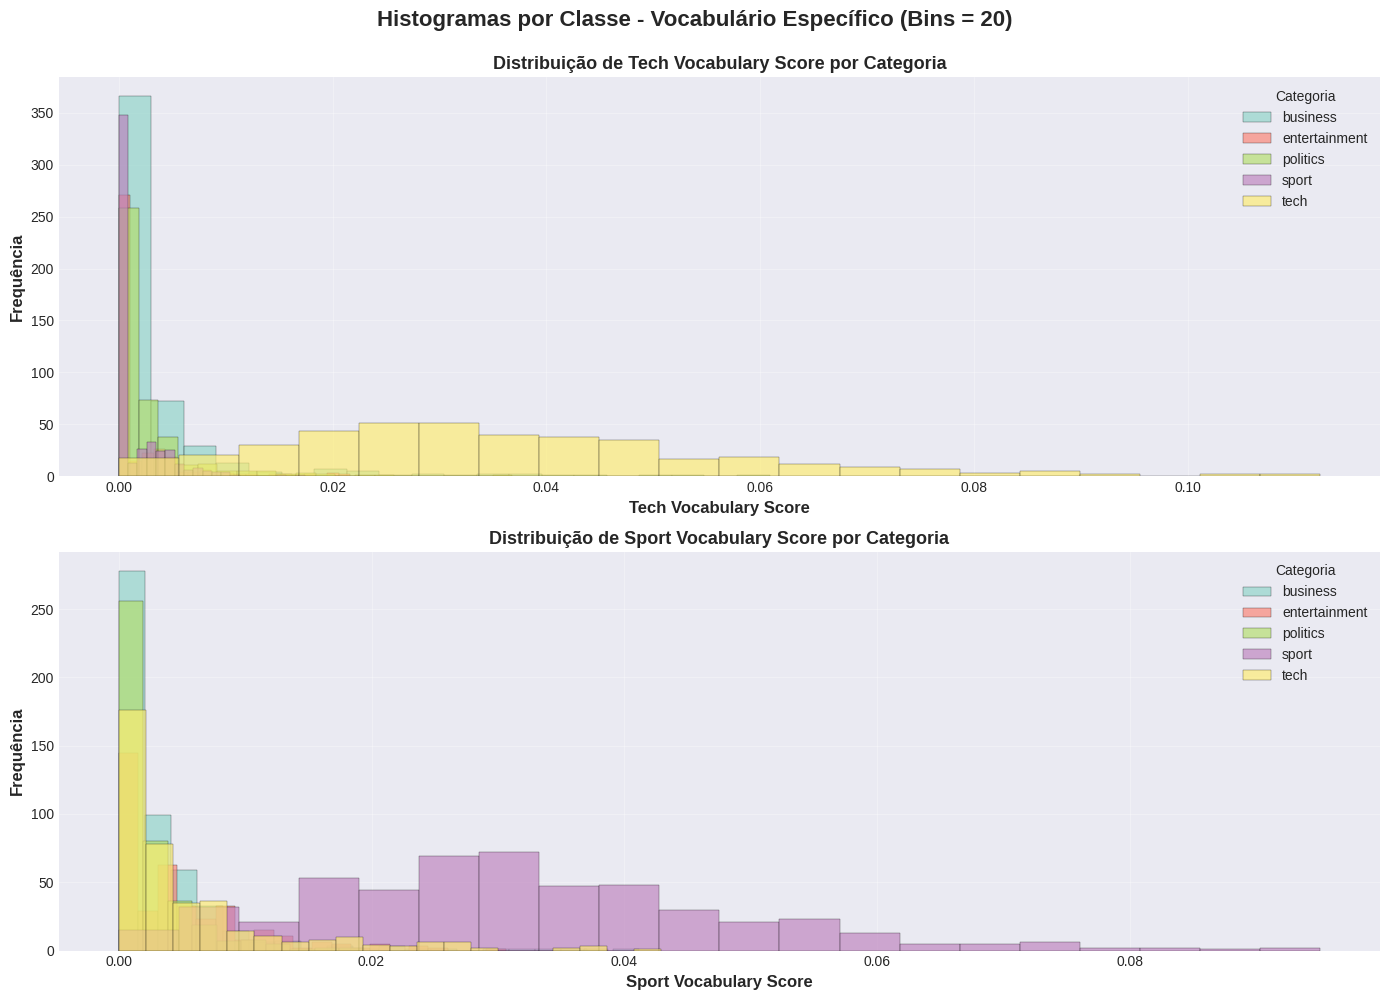

In [21]:
bins2 = 20

fig, axes = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle(f'Histogramas por Classe - Vocabulário Específico (Bins = {bins2})', fontsize=16, fontweight='bold', y=0.995)

# Histograma da Feature 1
ax1 = axes[0]
for i, category in enumerate(categories):
  data = df[df['category'] == category][feature1]
  ax1.hist(data, bins=bins2, alpha=0.65, label=category, color=colors[i], edgecolor='black', linewidth=0.3)

ax1.set_xlabel(f'{feature1_label}', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequência', fontsize=12, fontweight='bold')
ax1.set_title(f'Distribuição de {feature1_label} por Categoria', fontsize=13, fontweight='bold')
ax1.legend(title='Categoria', fontsize=10, loc='upper right')
ax1.grid(True, alpha=0.3)

# Histograma da Feature 2
ax2 = axes[1]
for i, category in enumerate(categories):
  data = df[df['category'] == category][feature2]
  ax2.hist(data, bins=bins2, alpha=0.65, label=category, color=colors[i], edgecolor='black', linewidth=0.3)

ax2.set_xlabel(f'{feature2_label}', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequência', fontsize=12, fontweight='bold')
ax2.set_title(f'Distribuição de {feature2_label} por Categoria', fontsize=13, fontweight='bold')
ax2.legend(title='Categoria', fontsize=10, loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## **DISCUSSÃO DOS HISTOGRAMAS**

## **Análise do Ponto de Vista de Classificação usando Aprendizado de Máquina**
Os histogramas revelam uma separabilidade excepcional entre as categorias TECH e SPORT em relação às suas respectivas features de vocabulário específico. Para tech_vocab_score, observa-se que artigos da categoria TECH apresentam média de 0.0355, representando uma diferença de 11 a 25 vezes maior comparada às demais categorias (business: 0.0031, politics: 0.0023, entertainment: 0.0018, sport: 0.0014). Esta separação é visualmente clara nos histogramas, onde TECH forma um pico distinto na região de 0.03-0.05, enquanto as outras categorias concentram-se próximo a zero. Similarmente, para sport_vocab_score, a categoria SPORT domina com média de 0.0316, sendo 6 a 14 vezes superior às demais categorias. O heatmap confirma este padrão ideal, mostrando valores altos na diagonal principal (TECH em vocabulário TECH e SPORT em vocabulário SPORT), evidenciando que as features capturam corretamente a essência semântica de cada categoria.


## **Discussão sobre os Tamanhos dos Bins**
A comparação entre bins = 6 e bins = 20 ilustra o trade-off clássico entre suavização e granularidade na visualização de distribuições. Com bins = 6, os histogramas apresentam uma visão mais generalizada e suave, facilitando a identificação imediata do padrão principal: TECH e SPORT destacam-se claramente de um "bloco" compacto formado pelas outras três categorias próximas a zero. Esta configuração é ideal para apresentações e relatórios, pois comunica o insight principal sem ruído visual. Já com bins = 20, obtém-se maior resolução dos detalhes, revelando que a distribuição de TECH é aproximadamente normal com ligeira assimetria positiva, e que existem alguns artigos de TECH com scores baixos (possíveis outliers ou artigos menos técnicos). Porém, bins = 20 também introduz bins vazios e flutuações que podem dificultar a interpretação, especialmente para audiências não-técnicas. Para este dataset específico, bins entre 15-25 representa o equilíbrio ideal: captura padrões relevantes sem perder a clareza visual, sendo adequado tanto para análise exploratória quanto para discussões sobre separabilidade de classes em machine learning.

# 6. ANÁLISE ESTATÍSTICA DAS FEATURES POR CLASSE

In [22]:
for feature, label in [(feature1, feature1_label), (feature2, feature2_label)]:
  print(f"\n{'='*80}")
  print(f"Feature: {label}")
  print(f"{'='*80}\n")

  stats_by_class = df.groupby('category')[feature].describe()
  print(stats_by_class.round(4))

  print(f"\nOrdenação por média (decrescente):")
  mean_sorted = df.groupby('category')[feature].mean().sort_values(ascending=False)
  for i, (cat, val) in enumerate(mean_sorted.items(), 1):
    print(f"{i}. {cat:15s}: {val:.4f}")


Feature: Tech Vocabulary Score

               count    mean     std  min     25%     50%     75%     max
category                                                                 
business       510.0  0.0031  0.0073  0.0  0.0000  0.0000  0.0033  0.0609
entertainment  386.0  0.0018  0.0038  0.0  0.0000  0.0000  0.0024  0.0216
politics       417.0  0.0023  0.0042  0.0  0.0000  0.0000  0.0030  0.0368
sport          511.0  0.0014  0.0025  0.0  0.0000  0.0000  0.0024  0.0174
tech           401.0  0.0355  0.0202  0.0  0.0214  0.0322  0.0463  0.1124

Ordenação por média (decrescente):
1. tech           : 0.0355
2. business       : 0.0031
3. politics       : 0.0023
4. entertainment  : 0.0018
5. sport          : 0.0014

Feature: Sport Vocabulary Score

               count    mean     std  min     25%     50%     75%     max
category                                                                 
business       510.0  0.0030  0.0050  0.0  0.0000  0.0000  0.0043  0.0412
entertainment  386.0  

# 7. MATRIZ DE CONFUSÃO VISUAL

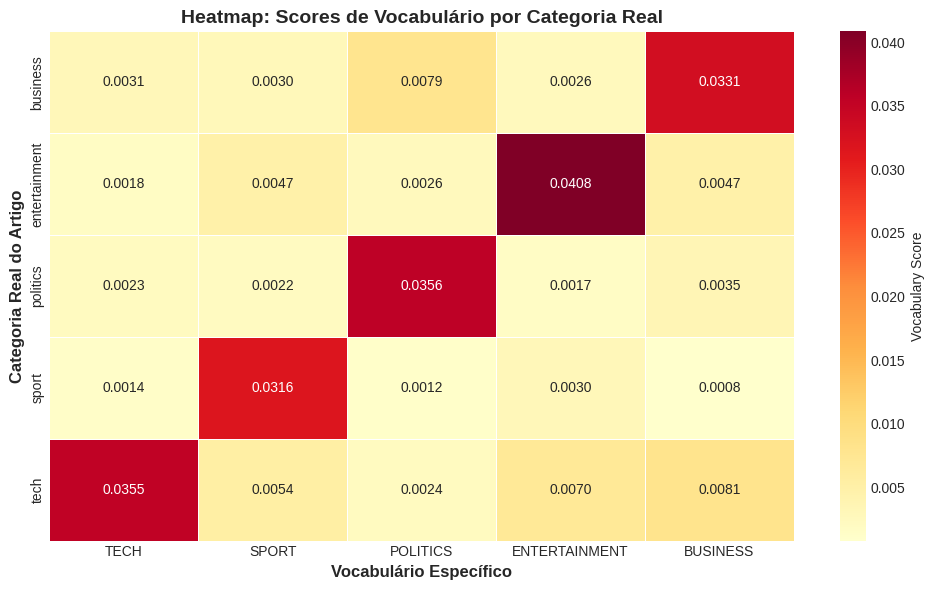

In [23]:
# Calcular média de todos os vocab scores por categoria
vocab_features = [f'{cat}_vocab_score' for cat in VOCABULARY.keys()]
heatmap_data = df.groupby('category')[vocab_features].mean()

heatmap_data.columns = [col.replace('_vocab_score', '').upper() for col in heatmap_data.columns]

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='YlOrRd', cbar_kws={'label': 'Vocabulary Score'}, linewidths=0.5)
plt.title('Heatmap: Scores de Vocabulário por Categoria Real', fontsize=14, fontweight='bold')
plt.xlabel('Vocabulário Específico', fontsize=12, fontweight='bold')
plt.ylabel('Categoria Real do Artigo', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()



---



# **Seção B - Considerando o primeiro trabalho, defina um experimento em que dados são coletados de uma variável de interesse do seu trabalho. Produza dados artificiais, plote o histograma e a distribuição que aproxime os dados. Em seguida, defina estudos como o exemplo da pizza explicado em sala, sempre partido da versão não padronizada e depois os cálculos na versão padronizada. Sempre considerando o contexto do seu primeiro trabalho.**


#### O Experimento:

Um desenvolvedor de sistemas acabou de ser contratado na empresa de notícias BBC. E a primeira tarefa dele é uma classificação automática de notícias da BCC, pois a mesma quer validar se novos artigos de tecnologia seguem o mesmo padrão de vocabulário dos artigos históricos.

E o sistema usa o `tech_vocab_score` (proporção de palavras técnicas) para identificar artigos de TECNOLOGIA.

E para isto ele precisa:
> 1. Analisar a distribuição histórica de tech_vocab_score
  2. Ajustar uma distribuição normal aos dados
  3. Simular novos artigos baseados nessa distribuição
  4. Calcular probabilidades relevantes para tomada de decisão


#### **VARIÁVEL DE INTERESSE**:
**tech_vocab_score** = proporção de palavras técnicas no texto (palavras como: technology, software, computer, internet, digital, etc.)


In [24]:
tech_articles  = df[df['category'] == 'tech']['tech_vocab_score']
tech_articles.describe()

,tech_vocab_score
count,401.000000
mean,0.035479
std,0.020241
min,0.000000
25%,0.021374
50%,0.032184
75%,0.046332
max,0.112360


In [25]:
media_tech_vocab_score = tech_articles.mean()
desvio_tech_vocab_score = tech_articles.std()

print(f"Distribuição ajustada: Normal(μ = {media_tech_vocab_score:.6f}, σ = {desvio_tech_vocab_score:.6f}")

Distribuição ajustada: Normal(μ = 0.035479, σ = 0.020241


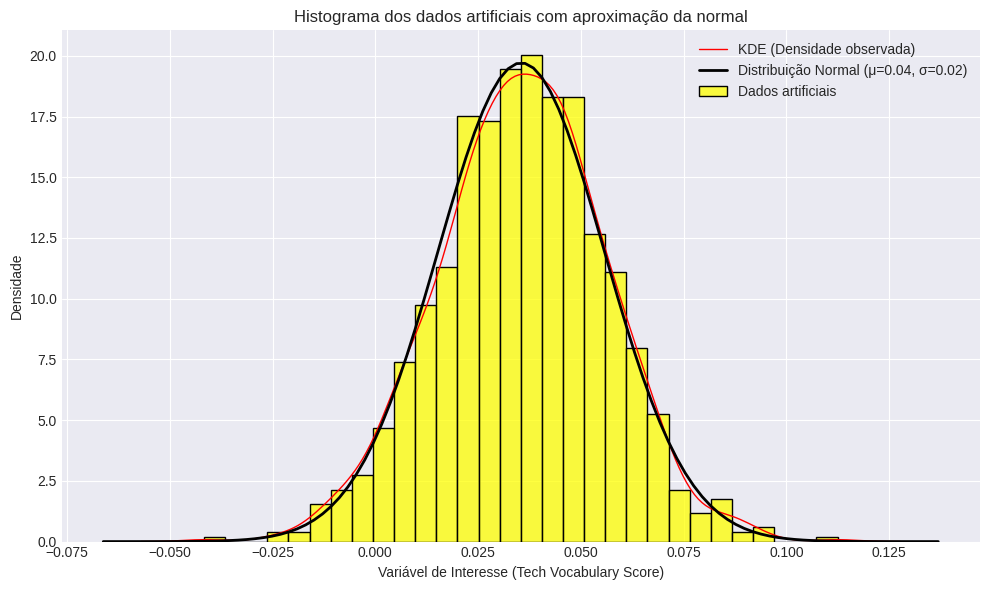

In [26]:
np.random.seed(49)

N_AMOSTRA = 1_000

artificial_data = np.random.normal(loc=media_tech_vocab_score, scale=desvio_tech_vocab_score, size=N_AMOSTRA)

plt.figure(figsize=(10, 6))
fig.suptitle('Análise de Distribuição - tech_vocab_score (Artigos TECH)', fontsize=16, fontweight='bold')

sns.histplot(artificial_data , bins='auto', stat="density", color="yellow", label="Dados artificiais")
sns.kdeplot(data=artificial_data, color="red", linewidth=1, label="KDE (Densidade observada)")
xmin, xmax = plt.xlim()
x_range = np.linspace(xmin, xmax, 100)
p = norm.pdf(x_range, media_tech_vocab_score, desvio_tech_vocab_score) # normal
plt.plot(x_range, p, 'k', linewidth=2, label=f"Distribuição Normal (μ={media_tech_vocab_score:.2f}, σ={desvio_tech_vocab_score:.2f})")

plt.title('Histograma dos dados artificiais com aproximação da normal')
plt.xlabel(f'Variável de Interesse ({feature1_label})')
plt.ylabel(f'Densidade')
plt.legend()

plt.tight_layout()
plt.show()



---



# **Questão B - Considerando o primeiro trabalho, defina um experimento em que dados são coletados de uma variável de interesse do seu trabalho. Produza dados artificiais, plote o histograma e a distribuição que aproxime os dados. Em seguida, defina estudos como o exemplo da pizza explicado em sala, sempre partido da versão não padronizada e depois os cálculos na versão padronizada. Sempre considerando o contexto do seu primeiro trabalho. Use uma função de Python e uma tabela para obter os valores de probabilidade.**

## ESTUDOS DE PROBABILIDADE - VERSÃO NÃO PADRONIZADA

### 1.1 Qual a probabilidade de um artigo de TECH ter score > 0.05?

In [27]:
x1 = 0.05
prob1_complementar = norm.cdf(x1, media_tech_vocab_score, desvio_tech_vocab_score)
prob1 = 1 - prob1_complementar

print(f"Cálculo (Versão NÃO padronizada):")
print(f"P(X > {x1}) = 1 - P(X ≤ {x1})")
print(f"P(X > {x1}) = 1 - Φ({(x1-media_tech_vocab_score)/desvio_tech_vocab_score:.2f})")
print(f"P(X > {x1}) = {prob1:.4f}")

Cálculo (Versão NÃO padronizada):
P(X > 0.05) = 1 - P(X ≤ 0.05)
P(X > 0.05) = 1 - Φ(0.72)
P(X > 0.05) = 0.2366


In [28]:
print(f"RESPOSTA: {prob1*100:.2f} % dos artigos de TECH têm score > 0.05")
print(f"Ou seja, aproximadamente {int(prob1 * len(tech_articles))} de {len(tech_articles)} artigos")

RESPOSTA: 23.66 % dos artigos de TECH têm score > 0.05
Ou seja, aproximadamente 94 de 401 artigos


### 1.2 Qual a probabilidade de um artigo de TECH ter score ≤ 0.03?

In [29]:
x2 = 0.03
prob2 = norm.cdf(x2, media_tech_vocab_score, desvio_tech_vocab_score)

print(f"Cálculo (Versão NÃO padronizada):")
print(f"P(X ≤ {x2}) = Φ((x - μ)/σ)")
print(f"P(X ≤ {x2}) = {prob2:.4f}")

Cálculo (Versão NÃO padronizada):
P(X ≤ 0.03) = Φ((x - μ)/σ)
P(X ≤ 0.03) = 0.3933


In [30]:
print(f"RESPOSTA: {prob2*100:.2f}% dos artigos de TECH têm score ≤ 0.03")
print(f"Aproximadamente {int(prob2 * len(tech_articles))} de {len(tech_articles)} artigos")

RESPOSTA: 39.33% dos artigos de TECH têm score ≤ 0.03
Aproximadamente 157 de 401 artigos


### 1.3 Qual a probabilidade de ter score entre 0.03 e 0.05?

In [31]:
x3_lower = 0.03
x3_upper = 0.05
prob3 = norm.cdf(x3_upper, media_tech_vocab_score, desvio_tech_vocab_score) - norm.cdf(x3_lower, media_tech_vocab_score, desvio_tech_vocab_score)

print(f"Cálculo (Versão NÃO padronizada):")
print(f"P({x3_lower} < X < {x3_upper}) = P(X < {x3_upper}) - P(X < {x3_lower})")
print(f"P({x3_lower} < X < {x3_upper}) = {norm.cdf(x3_upper, media_tech_vocab_score, desvio_tech_vocab_score):.4f} - {norm.cdf(x3_lower, media_tech_vocab_score, desvio_tech_vocab_score):.4f}")
print(f"P({x3_lower} < X < {x3_upper}) = {prob3:.4f}")

Cálculo (Versão NÃO padronizada):
P(0.03 < X < 0.05) = P(X < 0.05) - P(X < 0.03)
P(0.03 < X < 0.05) = 0.7634 - 0.3933
P(0.03 < X < 0.05) = 0.3701


In [32]:
print(f"RESPOSTA: {prob3*100:.2f} % dos artigos estão neste intervalo")

RESPOSTA: 37.01 % dos artigos estão neste intervalo




---



##ESTUDOS DE PROBABILIDADE - VERSÃO PADRONIZADA (Z-SCORE)

In [33]:
def calculate_z_score(x):
  return float(round((x - media_tech_vocab_score) / desvio_tech_vocab_score, 4))

### 2.1 Qual a probabilidade de um artigo de TECH ter score > 0.05?

In [34]:
x1 = 0.05
z1 = calculate_z_score(x1)
prob1_z_complementar = norm.cdf(z1)
prob1_z = 1 - prob1_z_complementar

print(f"Cálculo (Versão PADRONIZADA):")
print("Z = (X - μ) / σ")
print(f"Z = {z1:.2f}")

Cálculo (Versão PADRONIZADA):
Z = (X - μ) / σ
Z = 0.72


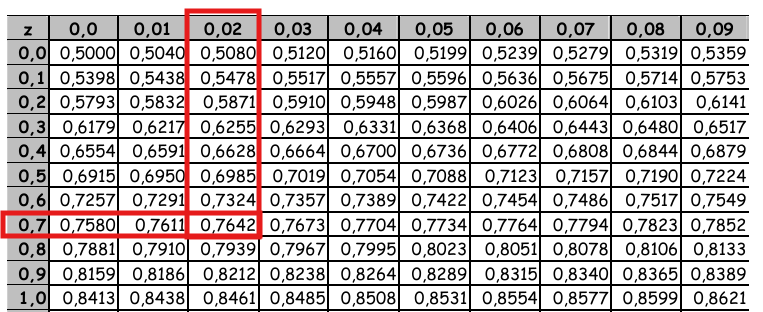

In [35]:
print(f" Calcular probabilidade usando tabela Z:")
print(f"P(X > {x1}) = P(Z > {z1:.2f})")
print(f"P(Z > {z1:.2f}) = 1 - P(Z ≤ {z1:.2f})")
print(f"P(Z > {z1:.2f}) = 1 - Φ({z1:.2f})")
print(f"P(Z > {z1:.2f}) = 1 - {prob1_z_complementar:.4f}")
print(f"P(Z > {z1:.2f}) = {prob1_z:.4f}")

print(f"\nRESPOSTA: {prob1_z*100:.2f} % (Mesmo resultado)")

 Calcular probabilidade usando tabela Z:
P(X > 0.05) = P(Z > 0.72)
P(Z > 0.72) = 1 - P(Z ≤ 0.72)
P(Z > 0.72) = 1 - Φ(0.72)
P(Z > 0.72) = 1 - 0.7634
P(Z > 0.72) = 0.2366

RESPOSTA: 23.66 % (Mesmo resultado)


### 2.2 Qual a probabilidade de um artigo de TECH ter score ≤ 0.03?

In [36]:
x2 = 0.03
z2 = calculate_z_score(x2)
prob2_z = norm.cdf(z2)

print(f"Cálculo (Versão PADRONIZADA):")
print(f"Z = (X - μ) / σ")
print(f"Z = {z2:.2f}")

Cálculo (Versão PADRONIZADA):
Z = (X - μ) / σ
Z = -0.27


In [37]:
print(f"Calcular probabilidade:")
print(f"P(X ≤ {x2}) = P(Z ≤ {z2:.2f})")
print(f"P(Z ≤ {z2:.2f}) = Φ({z2:.2f})")
print(f"P(Z ≤ {z2:.2f}) = {prob2_z:.4f}")

print(f"\nRESPOSTA: {prob2_z*100:.2f} % (Mesmo resultado)")

Calcular probabilidade:
P(X ≤ 0.03) = P(Z ≤ -0.27)
P(Z ≤ -0.27) = Φ(-0.27)
P(Z ≤ -0.27) = 0.3933

RESPOSTA: 39.33 % (Mesmo resultado)


### 2.3 Qual a probabilidade de ter score entre 0.03 e 0.05?

In [38]:
x3_lower = 0.03
x3_upper = 0.05
z3_lower = calculate_z_score(x3_lower)
z3_upper = calculate_z_score(x3_upper)
prob3_z = norm.cdf(z3_upper) - norm.cdf(z3_lower)

print(f"Cálculo (Versão PADRONIZADA):")
print(f"Calcular Z-scores:")
print(f"Z_lower =  {z3_lower:.4f}")
print(f"Z_upper = {z3_upper:.4f}")

Cálculo (Versão PADRONIZADA):
Calcular Z-scores:
Z_lower =  -0.2707
Z_upper = 0.7174


In [39]:

print(f"Calcular probabilidade:")
print(f"P(0.03 < X < 0.05) = P({z3_lower:.4f} < Z < {z3_upper:.4f})")
print(f"P({z3_lower:.4f} < Z < {z3_upper:.4f}) = Φ({z3_upper:.4f}) - Φ({z3_lower:.4f})")
print(f"P({z3_lower:.4f} < Z < {z3_upper:.4f}) = {norm.cdf(z3_upper):.4f} - {norm.cdf(z3_lower):.4f}")
print(f"P({z3_lower:.4f} < Z < {z3_upper:.4f}) = {prob3_z:.4f}")

print(f"\nRESPOSTA: {prob3_z*100:.2f} % (Mesmo resultado)")

Calcular probabilidade:
P(0.03 < X < 0.05) = P(-0.2707 < Z < 0.7174)
P(-0.2707 < Z < 0.7174) = Φ(0.7174) - Φ(-0.2707)
P(-0.2707 < Z < 0.7174) = 0.7634 - 0.3933
P(-0.2707 < Z < 0.7174) = 0.3701

RESPOSTA: 37.01 % (Mesmo resultado)




---



# **Questão C - Para s = 0.80, reproduza a mesma simulação do slide anterior. Faça o cálculo explicitamente, usando a equação. Compare os resultados. Mostre o histograma também para as 10 primeiras amostras, conforme exemplo dos próximos slides.**

Foi refeita a mesma simulação do evento de 48 caras de 242.485 amostras com 50 lançamentos, mas agora com `s = 0.80`

In [40]:
N_AMOSTRAS_MOEDAS = 242_485
np.random.seed(49)
artificial_samples = np.random.binomial(n=50, p=0.80, size=N_AMOSTRAS_MOEDAS)

np.sum(artificial_samples == 48) / N_AMOSTRAS_MOEDAS

np.float64(0.0009691321112646143)

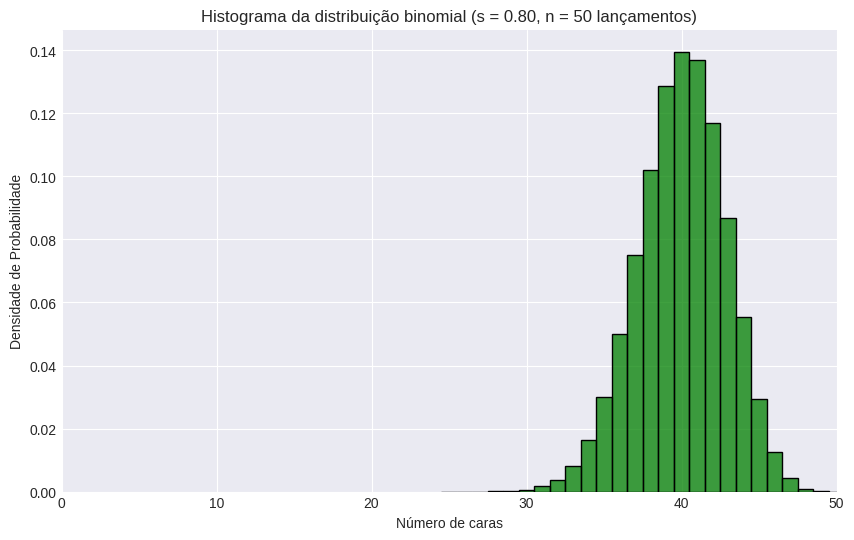

In [41]:
plt.figure(figsize=(10, 6))

sns.histplot(data=artificial_samples, stat='density', color="green", discrete=True, binwidth=1)

plt.title("Histograma da distribuição binomial (s = 0.80, n = 50 lançamentos)")
plt.xlabel("Número de caras")
plt.ylabel("Densidade de Probabilidade")
plt.xlim(0, 50)
plt.show()

In [42]:
n = 50
s = 0.80
k = 48

fac_n = math.factorial(n)
fac_nk = math.factorial(n - k)
fac_k = math.factorial(k)

com = fac_n / (fac_k * fac_nk)
print(f"Resultado da combinação:\nSão ao todo {int(com)} formas de tirar 48 caras em 50 lançamentos")

prob = com * (s ** k) * ((1 - s) ** (n - k))
print(f"\nProbabilidade P(X = 48): {prob:.6f}")

Resultado da combinação:
São ao todo 1225 formas de tirar 48 caras em 50 lançamentos

Probabilidade P(X = 48): 0.001093


> A análise comparativa demonstra uma alta convergência entre o modelo teórico e o prático: o cálculo probabilístico (aprox. 0,109%) e a frequência simulada (aprox. 0,103%) apresentaram discrepância mínima. Além disso, evidencia-se a sensibilidade do modelo à alteração do parâmetro $s$. A redução da taxa de sucesso de 0,95 para 0,80 transformou o cenário drasticamente: o resultado de 48 caras, anteriormente o evento modal (mais provável, com 26,1%), foi deslocado para a extremidade da distribuição, tornando-se uma ocorrência estatisticamente rara.

### Histogramas das 10 primeiras amostras geradas:

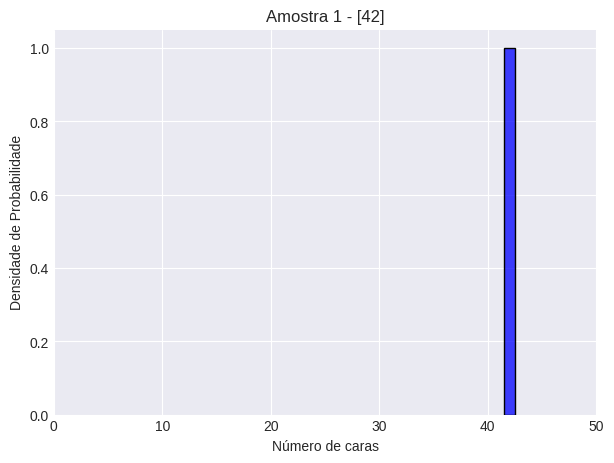

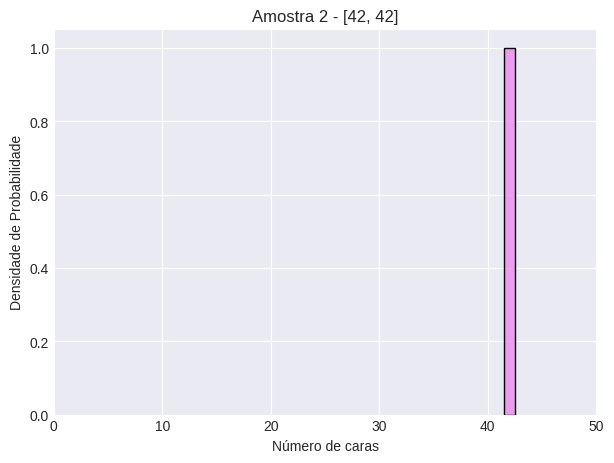

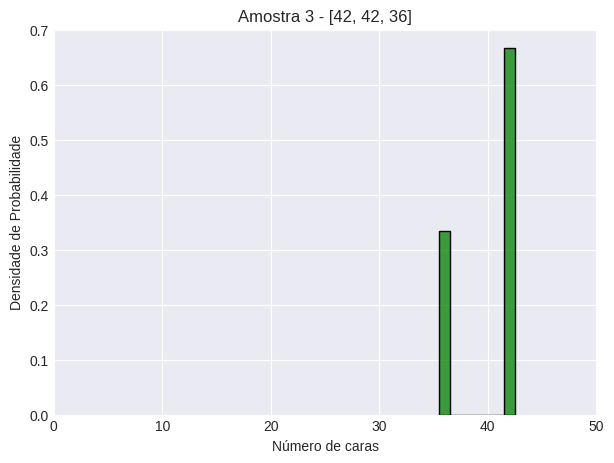

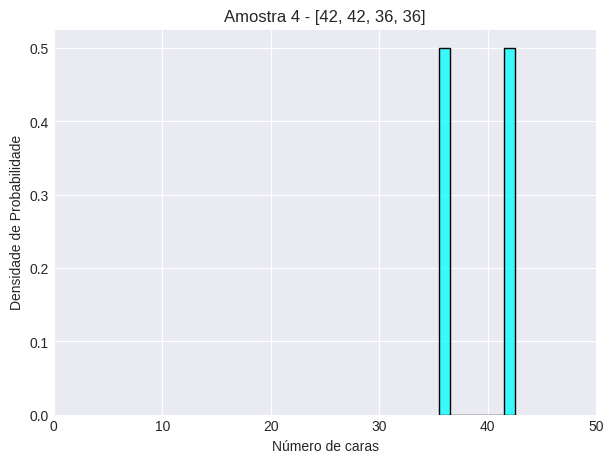

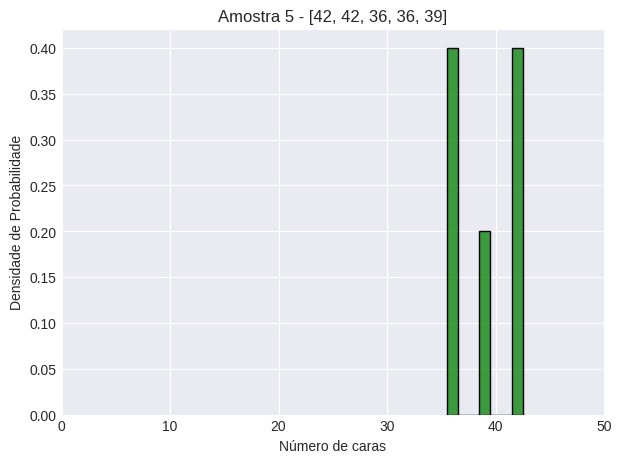

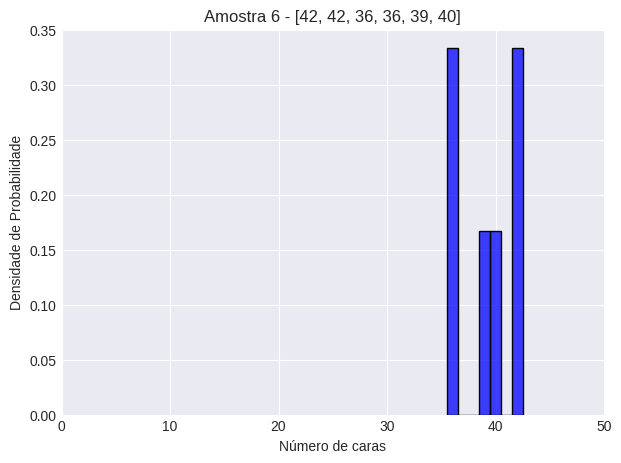

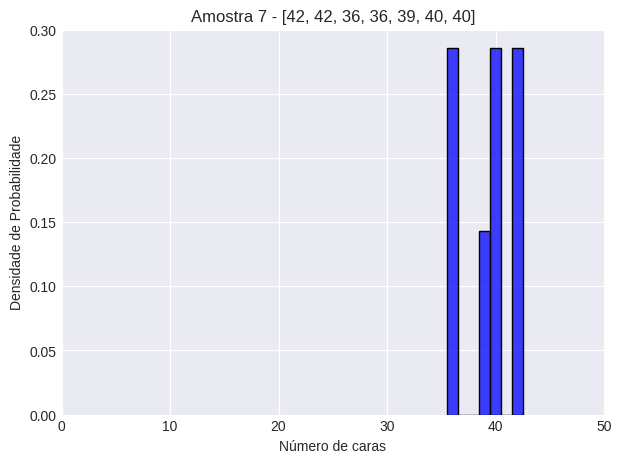

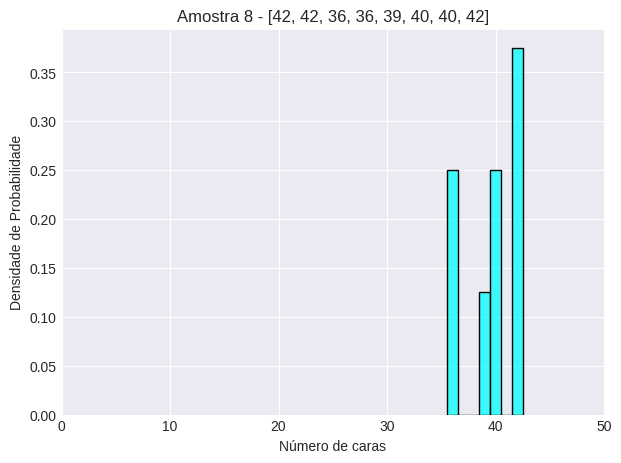

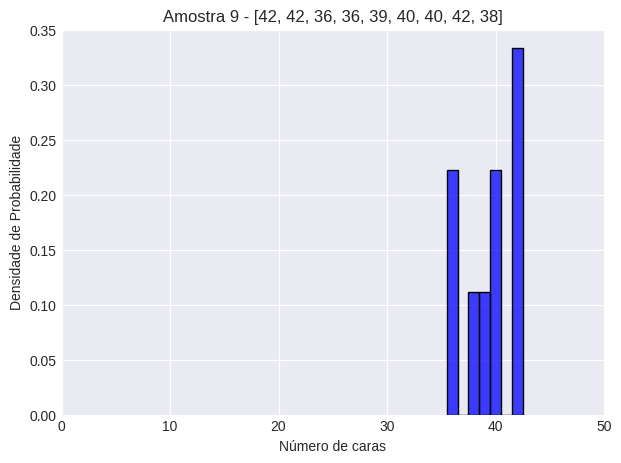

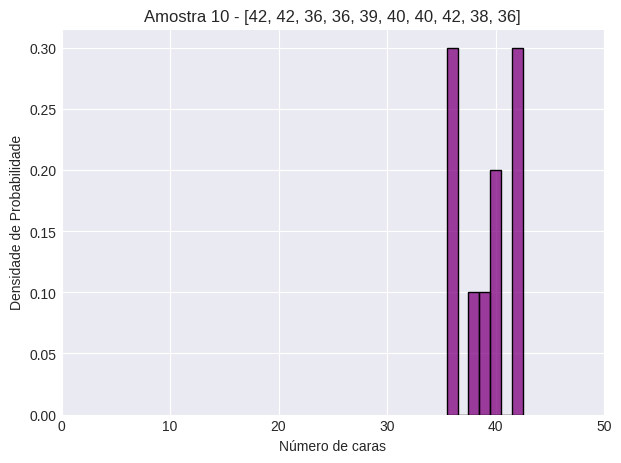

In [43]:
COLORS =["red", "green", "yellow", "cyan", "pink", "blue", "orange", "purple", "violet"]

for num in list(range(1, 11)):
    samples = artificial_samples[:num]

    plt.figure(figsize=(7, 5))

    sns.histplot(x=samples, stat='density', color=COLORS[np.random.randint(1, 9)], discrete=True, binwidth=1)

    plt.title(f'Amostra {num} - [{", ".join(str(samp) for samp in samples)}]')
    plt.xlabel('Número de caras')
    plt.ylabel('Densidade de Probabilidade')
    plt.xlim(0, 50)
    plt.show()



---



# **Parte 2 - Sample distribution and sampling distribution TLC p-value**

## **Seção A - A partir do que foi feito na Atividade 2 “Considerando o primeiro trabalho, defina um experimento em que dados são coletados de uma variável de interesse do seu trabalho”, crie uma população artificial dessa variável com uma distribuição Gaussiana e demonstre sample distribution and sampling distribution. Faça avaliações de probabilidade de possíveis eventos.**

### **CRIAÇÃO DA POPULAÇÃO**

Utilizaremos a mesma variavel de interrese e parâmetros de média e desvio padrão definidos na Parte 1.B, para criar uma grande população Gaussiana.

In [44]:
N_POP = 10_000
mu_population = media_tech_vocab_score
sigma_population = desvio_tech_vocab_score

np.random.seed(49)
population = np.random.normal(mu_population, sigma_population, N_POP)

In [45]:
n = 50
sample = np.random.choice(population, size=n, replace=False)

#### **SAMPLING DISTRIBUTION**

In [46]:
num_samples = 1000
sample_size = 50

sample_means = []
for i in range(num_samples):
  sample_i = np.random.choice(population, size=sample_size, replace=False)
  sample_means.append(sample_i.mean())

sample_means = np.array(sample_means)

standard_error_theoretical = sigma_population / np.sqrt(sample_size)
standard_error_theoretical

np.float64(0.002862557621448849)

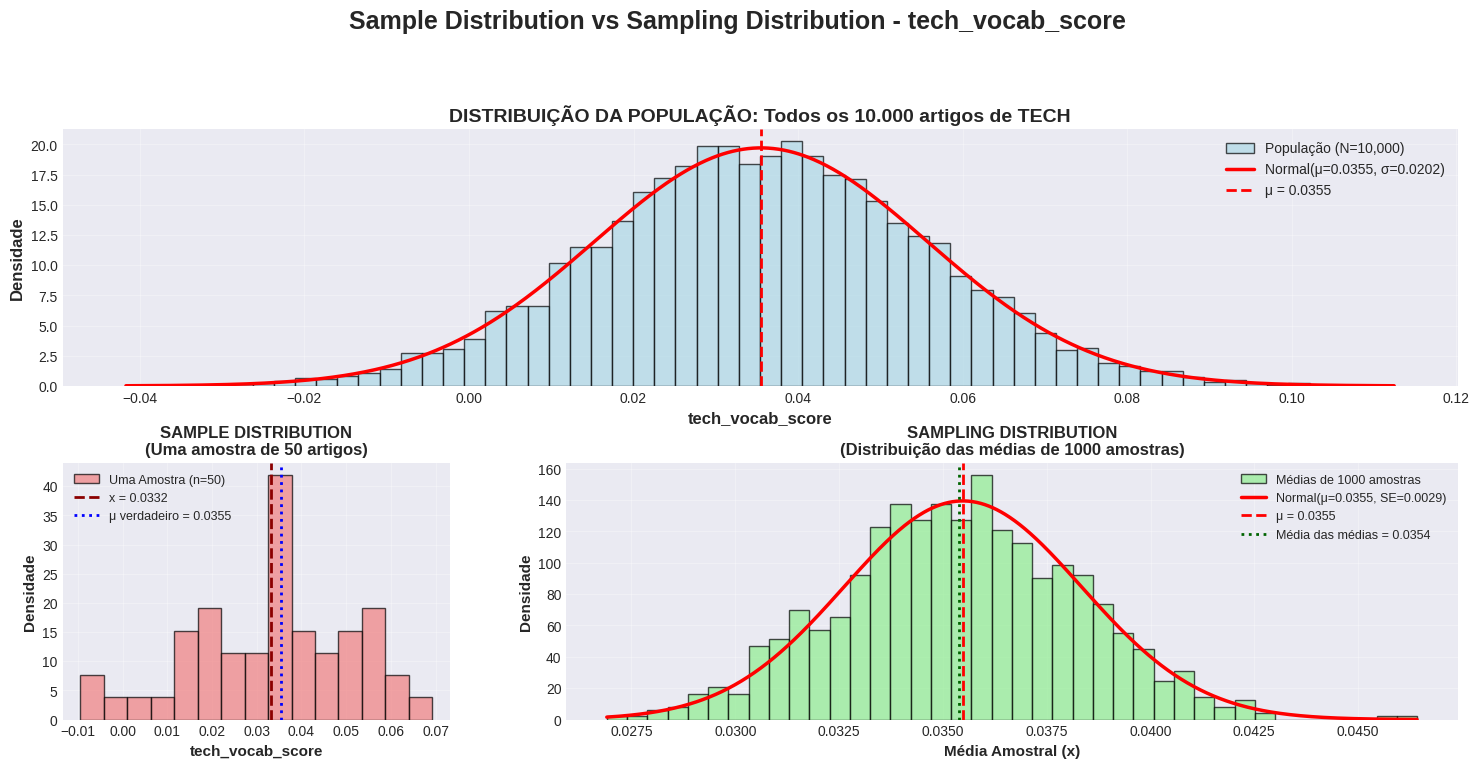

In [47]:
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

fig.suptitle('Sample Distribution vs Sampling Distribution - tech_vocab_score', fontsize=18, fontweight='bold', y=0.98)

# Population
ax1 = fig.add_subplot(gs[0, :])
ax1.hist(population, bins=60, density=True, alpha=0.7, color='lightblue', edgecolor='black', label=f'População (N={N_POP:,})')
x_range = np.linspace(population.min(), population.max(), 1000)
ax1.plot(x_range, norm.pdf(x_range, mu_population, sigma_population), 'r-', linewidth=2.5, label=f'Normal(μ={mu_population:.4f}, σ={sigma_population:.4f})')
ax1.axvline(mu_population, color='red', linestyle='--', linewidth=2, label=f'μ = {mu_population:.4f}')
ax1.set_xlabel('tech_vocab_score', fontsize=12, fontweight='bold')
ax1.set_ylabel('Densidade', fontsize=12, fontweight='bold')
ax1.set_title('DISTRIBUIÇÃO DA POPULAÇÃO: Todos os 10.000 artigos de TECH', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)


# Sample Distribution
ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(sample, bins=15, density=True, alpha=0.7, color='lightcoral', edgecolor='black', label=f'Uma Amostra (n={n})')
ax2.axvline(sample.mean(), color='darkred', linestyle='--', linewidth=2, label=f'x = {sample.mean():.4f}')
ax2.axvline(mu_population, color='blue', linestyle=':', linewidth=2, label=f'μ verdadeiro = {mu_population:.4f}')
ax2.set_xlabel('tech_vocab_score', fontsize=11, fontweight='bold')
ax2.set_ylabel('Densidade', fontsize=11, fontweight='bold')
ax2.set_title('SAMPLE DISTRIBUTION\n(Uma amostra de 50 artigos)', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Sampling Distribution
ax3 = fig.add_subplot(gs[1, 1:])
ax3.hist(sample_means, bins=40, density=True, alpha=0.7, color='lightgreen', edgecolor='black', label=f'Médias de {num_samples} amostras')
x_range_sampling = np.linspace(sample_means.min(), sample_means.max(), 1000)
ax3.plot(x_range_sampling, norm.pdf(x_range_sampling, mu_population, standard_error_theoretical), 'r-', linewidth=2.5, label=f'Normal(μ={mu_population:.4f}, SE={standard_error_theoretical:.4f})')
ax3.axvline(mu_population, color='red', linestyle='--', linewidth=2, label=f'μ = {mu_population:.4f}')
ax3.axvline(sample_means.mean(), color='darkgreen', linestyle=':', linewidth=2, label=f'Média das médias = {sample_means.mean():.4f}')
ax3.set_xlabel('Média Amostral (x)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Densidade', fontsize=11, fontweight='bold')
ax3.set_title('SAMPLING DISTRIBUTION\n(Distribuição das médias de 1000 amostras)', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

### **AVALIAÇÕES DE PROBABILIDADE DE EVENTOS**

#### **EVENTO 1: P(x̄ > 0.04)**

Se coletarmos uma amostra de 50 artigos, qual a probabilidade de a média amostral ser maior que 0.04?

In [48]:
x_event1 = 0.04
z_event1 = (x_event1 - mu_population) / standard_error_theoretical
prob_event1 = 1 - norm.cdf(z_event1)

In [49]:
print(f"\nCálculo usando Sampling Distribution:")
print(f"X̄ ~ N(μ = {mu_population:.6f}, SE = {standard_error_theoretical:.6f})")

print(f"\nZ = (x̄ - μ) / SE")
print(f"Z = ({x_event1} - {mu_population:.6f}) / {standard_error_theoretical:.6f}")
print(f"Z = {z_event1:.4f}")

print(f"\nP(x̄ > {x_event1}) = P(Z > {z_event1:.4f})")
print(f"P(x̄ > {x_event1}) = 1 - Φ({z_event1:.4f})")
print(f"P(x̄ > {x_event1}) = {prob_event1:.6f}")

prob_event1_empirical = np.mean(sample_means > x_event1)
print(f"\nVerificação Empírica (das 1000 amostras):")
print(f"Proporção observada: {prob_event1_empirical:.6f}")
print(f"Diferença do teórico: {abs(prob_event1 - prob_event1_empirical):.6f}")

print(f"\nRESPOSTA: {prob_event1*100:.2f} % de chance de x̄ > 0.04")
print(f"Em {int(prob_event1 * 1000)} das 1000 amostras coletadas, x̄ > 0.04")



Cálculo usando Sampling Distribution:
X̄ ~ N(μ = 0.035479, SE = 0.002863)

Z = (x̄ - μ) / SE
Z = (0.04 - 0.035479) / 0.002863
Z = 1.5792

P(x̄ > 0.04) = P(Z > 1.5792)
P(x̄ > 0.04) = 1 - Φ(1.5792)
P(x̄ > 0.04) = 0.057139

Verificação Empírica (das 1000 amostras):
Proporção observada: 0.050000
Diferença do teórico: 0.007139

RESPOSTA: 5.71 % de chance de x̄ > 0.04
Em 57 das 1000 amostras coletadas, x̄ > 0.04


#### **EVENTO 2: P(0.032 < x̄ < 0.038)**

Qual a probabilidade de a média amostral estar no intervalo [0.032, 0.038]? (Intervalo de confiança informal)

In [50]:
x_lower2 = 0.032
x_upper2 = 0.038
z_lower2 = (x_lower2 - mu_population) / standard_error_theoretical
z_upper2 = (x_upper2 - mu_population) / standard_error_theoretical
prob_event2 = norm.cdf(z_upper2) - norm.cdf(z_lower2)

In [51]:
print(f"Z_lower = ({x_lower2} - {mu_population:.6f}) / {standard_error_theoretical:.6f} = {z_lower2:.4f}")
print(f"Z_upper = ({x_upper2} - {mu_population:.6f}) / {standard_error_theoretical:.6f} = {z_upper2:.4f}")

print(f"\nP({x_lower2} < x̄ < {x_upper2}) = Φ({z_upper2:.4f}) - Φ({z_lower2:.4f})")
print(f"\nP({x_lower2} < x̄ < {x_upper2}) = {prob_event2:.6f}")

prob_event2_empirical = np.mean((sample_means > x_lower2) & (sample_means < x_upper2))
print(f"\nVerificação Empírica:")
print(f"Proporção observada: {prob_event2_empirical:.6f}")

print(f"\nRESPOSTA: {prob_event2*100:.2f} % das médias amostrais caem neste intervalo")
print(f"Aproximadamente {int(prob_event2 * 1000)} de 1000 amostras")

Z_lower = (0.032 - 0.035479) / 0.002863 = -1.2155
Z_upper = (0.038 - 0.035479) / 0.002863 = 0.8806

P(0.032 < x̄ < 0.038) = Φ(0.8806) - Φ(-1.2155)

P(0.032 < x̄ < 0.038) = 0.698629

Verificação Empírica:
Proporção observada: 0.677000

RESPOSTA: 69.86 % das médias amostrais caem neste intervalo
Aproximadamente 698 de 1000 amostras




---



## **Seção B - Aplique o TLC a função de distribuição gama e avalie quatro diferentes tamanhos de amostra, começando em 10.**

**Criação e Visualização da População Gamma**

In [52]:
shape_param = 3.0
scale_param = 1.5

mu_gamma = shape_param * scale_param
sigma_gamma = np.sqrt(shape_param * scale_param**2)

N_population = 100_000
population_gamma = np.random.gamma(shape_param, scale_param, N_population)


In [53]:
sample_sizes = [10, 30, 50, 100]
num_samples = 5000

Coletando amostras e calculando médias

In [54]:
sampling_distributions = {}

for n in sample_sizes:
  sample_means = []
  for i in range(num_samples):

    sample = np.random.choice(population_gamma, size=n, replace=False)
    sample_means.append(sample.mean())

  sample_means = np.array(sample_means)
  sampling_distributions[n] = sample_means

  mean_of_means = sample_means.mean()
  std_of_means = sample_means.std()
  se_theoretical = sigma_gamma / np.sqrt(n)

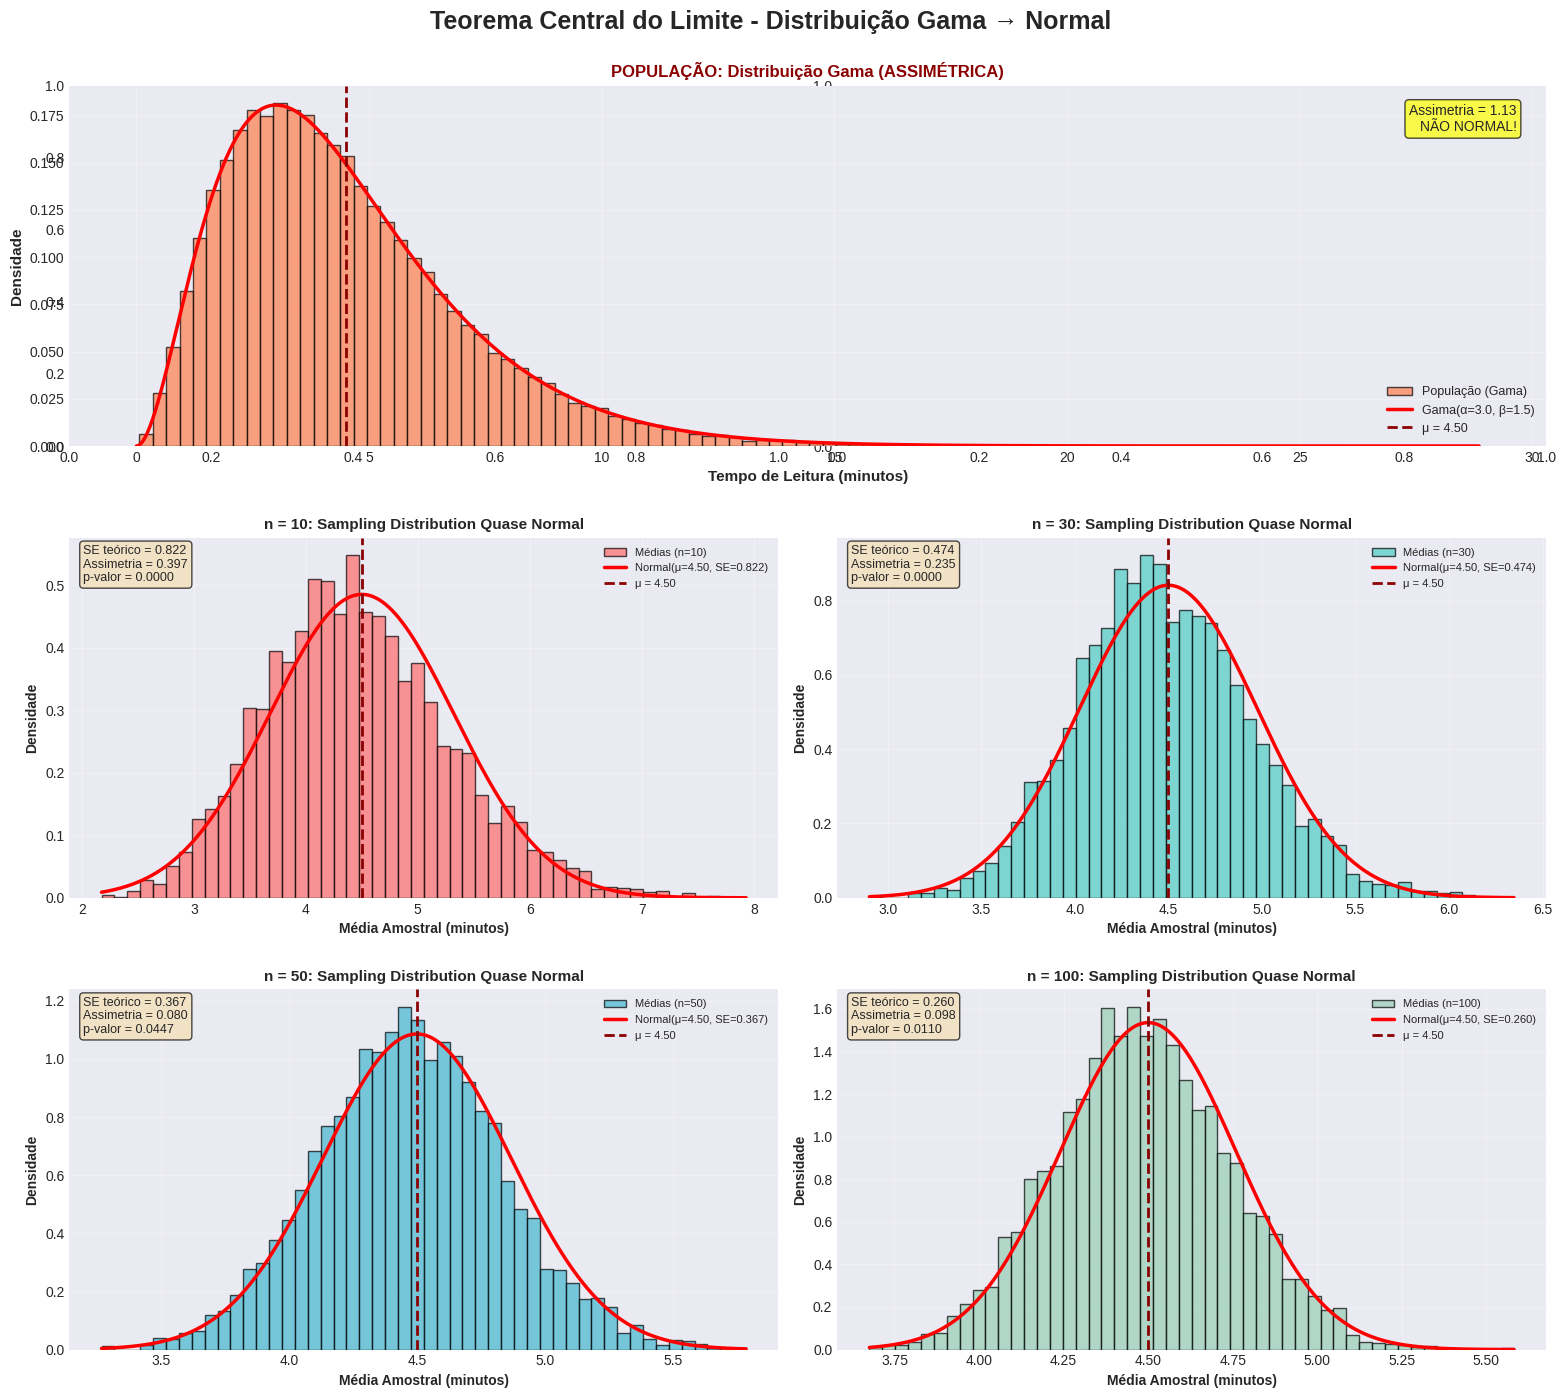

In [55]:
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle('Teorema Central do Limite - Distribuição Gama → Normal', fontsize=18, fontweight='bold', y=0.995)

gs = fig.add_gridspec(3, 2)

# População Original (Gama)
ax_pop = fig.add_subplot(gs[0, :]) #axes[0, 0]
ax_pop.hist(population_gamma, bins=100, density=True, alpha=0.7, color='coral', edgecolor='black', label='População (Gama)')

x_range = np.linspace(0, population_gamma.max(), 1000)
gamma_pdf = gamma.pdf(x_range, shape_param, scale=scale_param)
ax_pop.plot(x_range, gamma_pdf, 'r-', linewidth=2.5, label=f'Gama(α={shape_param}, β={scale_param})')

ax_pop.axvline(mu_gamma, color='darkred', linestyle='--', linewidth=2, label=f'μ = {mu_gamma:.2f}')
ax_pop.set_xlabel('Tempo de Leitura (minutos)', fontsize=11, fontweight='bold')
ax_pop.set_ylabel('Densidade', fontsize=11, fontweight='bold')
ax_pop.set_title('POPULAÇÃO: Distribuição Gama (ASSIMÉTRICA)', fontsize=12, fontweight='bold', color='darkred')
ax_pop.legend(fontsize=9)
ax_pop.grid(True, alpha=0.3)
ax_pop.text(0.98, 0.95, f'Assimetria = {stats.skew(population_gamma):.2f}\nNÃO NORMAL!', transform=ax_pop.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# Sampling Distributions
colors_sampling = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

for idx, n in enumerate(sample_sizes):
  row = (idx // 2) + 1
  col = idx % 2
  ax = axes[row, col]

  sample_means = sampling_distributions[n]
  se_theoretical = sigma_gamma / np.sqrt(n)

  # Histograma
  ax.hist(sample_means, bins=50, density=True, alpha=0.7,
          color=colors_sampling[idx], edgecolor='black',
          label=f'Médias (n={n})')

  # Curva normal teórica
  x_range_normal = np.linspace(sample_means.min(), sample_means.max(), 1000)
  normal_pdf = norm.pdf(x_range_normal, mu_gamma, se_theoretical)
  ax.plot(x_range_normal, normal_pdf, 'r-', linewidth=2.5,
          label=f'Normal(μ={mu_gamma:.2f}, SE={se_theoretical:.3f})')

  # Linha da média
  ax.axvline(mu_gamma, color='darkred', linestyle='--', linewidth=2,
              label=f'μ = {mu_gamma:.2f}')

  # Teste de normalidade
  _, p_value = stats.shapiro(sample_means[:5000])
  skewness = stats.skew(sample_means)

  ax.set_xlabel('Média Amostral (minutos)', fontsize=10, fontweight='bold')
  ax.set_ylabel('Densidade', fontsize=10, fontweight='bold')

  # Título com avaliação de normalidade
  normalidade = "NORMAL" if p_value > 0.05 else "Quase Normal"
  ax.set_title(f'n = {n}: Sampling Distribution {normalidade}',
                fontsize=11, fontweight='bold')

  ax.legend(fontsize=8)
  ax.grid(True, alpha=0.3)

  # Caixa de texto com estatísticas
  textstr = f'SE teórico = {se_theoretical:.3f}\nAssimetria = {skewness:.3f}\np-valor = {p_value:.4f}'
  ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.show()


## **Seção C - Faça um programa que mostra o passo a passo para calcular o p-value do evento abaixo (4 caras, 1 coroa). Coloque figuras para cada passo.**

**Contexto:**

Para determinar se uma moeda é "justa" (ou seja, não viciada), utilizamos o teste de hipóteses. A nossa Hipótese Nula ($H_0$) assume que a probabilidade de dar cara é $50\%$ ($p=0.5$). A nossa Hipótese Alternativa ($H_1$) sugere que a moeda é viciada ($p \neq 0.5$). Neste experimento, lançamos a moeda 5 vezes ($n=5$) e observamos o evento de 4 Caras e 1 Coroa. O p-value nos dirá a probabilidade de observarmos um resultado tão extremo quanto (ou mais extremo que) 4 caras, assumindo que a moeda é justa. Se essa probabilidade for muito baixa (geralmente $< 0.05$), rejeitamos a ideia de que a moeda é justa.

A distribuição de probabilidade para este evento é dada pela Distribuição Binomial:$$P(X=k) = \binom{n}{k} p^k (1-p)^{n-k}$$

Onde:

$n = 5$ (número total de lançamentos)

$k$ = número de caras

$p = 0.5$ (probabilidade de cara sob $H_0$)

**Passo 1: Visualizando a Distribuição Teórica**

Primeiro, vamos visualizar como uma moeda justa se comporta em 5 lançamentos.

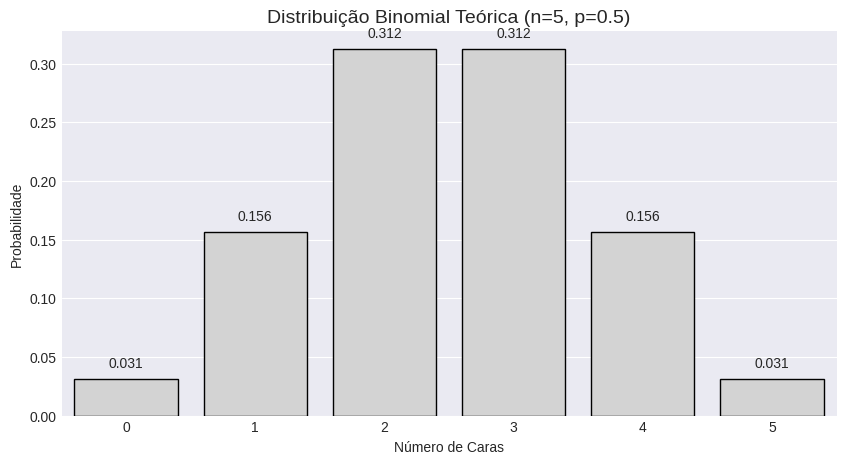

In [56]:
n_lancamentos = 5
p_justa = 0.5
k_observado = 4

x = np.arange(0, n_lancamentos + 1)
probabilidades = stats.binom.pmf(x, n_lancamentos, p_justa)

df_dist = pd.DataFrame({'Caras': x, 'Probabilidade': probabilidades})

plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df_dist, x='Caras', y='Probabilidade', color='lightgrey', edgecolor='black')
plt.title(f'Distribuição Binomial Teórica (n={n_lancamentos}, p={p_justa})', fontsize=14)
plt.ylabel('Probabilidade')
plt.xlabel('Número de Caras')

for i, p in enumerate(probabilidades):
  ax.text(i, p + 0.01, f'{p:.3f}', ha='center')

plt.show()

**Passo 2:** Calculando e Visualizando o P-Value

O p-value é a soma das probabilidades dos eventos "tão raros quanto" ou "mais raros que" o observado.

- **Unicaudal (One-sided)**: Probabilidade de obter 4 ou mais caras ($k \ge 4$).
- **Bicaudal (Two-sided)**: Probabilidade de obter um resultado tão extremo em qualquer direção (muitas caras OU muitas coroas). Como a distribuição é simétrica, multiplicamos o valor unicaudal por 2.

Probabilidade de obter 4 ou mais caras (One-sided): 0.1875
P-Value do teste (Two-sided): 0.3750


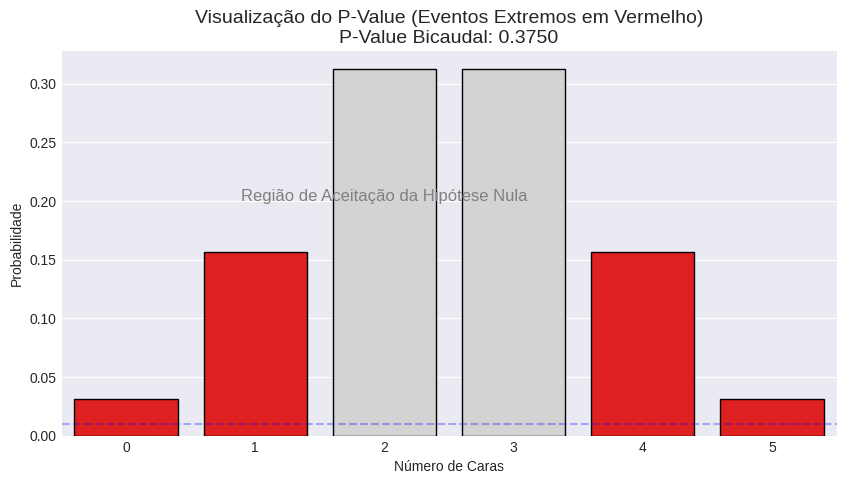

In [57]:
# 1. Calcular probabilidade dos eventos extremos (4 ou 5 caras)
# P(X >= 4)
p_value_one_sided = stats.binom.sf(k_observado - 1, n_lancamentos, p_justa)

p_value_two_sided = p_value_one_sided * 2

print(f"Probabilidade de obter 4 ou mais caras (One-sided): {p_value_one_sided:.4f}")
print(f"P-Value do teste (Two-sided): {p_value_two_sided:.4f}")

plt.figure(figsize=(10, 5))

cores = ['red' if (x >= k_observado or x <= (n_lancamentos - k_observado)) else 'lightgrey' for x in df_dist['Caras']]

ax = sns.barplot(data=df_dist, x='Caras', y='Probabilidade', palette=cores, edgecolor='black')

plt.title(f'Visualização do P-Value (Eventos Extremos em Vermelho)\nP-Value Bicaudal: {p_value_two_sided:.4f}', fontsize=14)
plt.ylabel('Probabilidade')
plt.xlabel('Número de Caras')

plt.axhline(y=0.01, color='blue', linestyle='--', alpha=0.3)
plt.text(2, 0.20, 'Região de Aceitação da Hipótese Nula', ha='center', color='grey', fontsize=12)

plt.show()

**Conclusão**

Considerando um nível de significância padrão de $\alpha = 0.05$ (5%), comparamos nosso p-value calculado:

$$\text{P-Value} (0.3750) > \alpha (0.05)$$

Conclusão: Nós **não rejeitamos a Hipótese Nula**.

Embora obter 4 caras em 5 lançamentos pareça um evento suspeito intuitivamente, estatisticamente, em uma amostra tão pequena ($n=5$), esse evento ocorre com frequência suficiente ($37.5\%$ das vezes um resultado tão extremo acontece ao acaso) para ser considerado apenas uma variação natural. Não há evidências estatísticas suficientes para afirmar que a moeda é viciada.



---



## **Seção D - Crie duas Gaussianas como mostrado abaixo (é só variar a média). Sortei 100 sequências de três valores na azul e para cada sequência calcule o p-value a partir da vermelha. Veja a seta vermelha que indica a partir de qual amostra é calculado p-value. Calcule a taxa de falso negativos (p-value acima de 5%).**

**Contexto:**

Nesta simulação, exploramos o conceito de Erro do Tipo II (Falso Negativo). Estabelecemos uma distribuição Vermelha como nossa Hipótese Nula ($H_0$) e uma distribuição Azul como a Hipótese Alternativa verdadeira ($H_1$). Ao coletar amostras pequenas ($n=3$) da distribuição Azul, testamos se elas são estatisticamente distinguíveis da Vermelha. Se o p-valor for alto ($> 0.05$), falhamos em rejeitar a hipótese nula incorreta, cometendo assim um falso negativo.

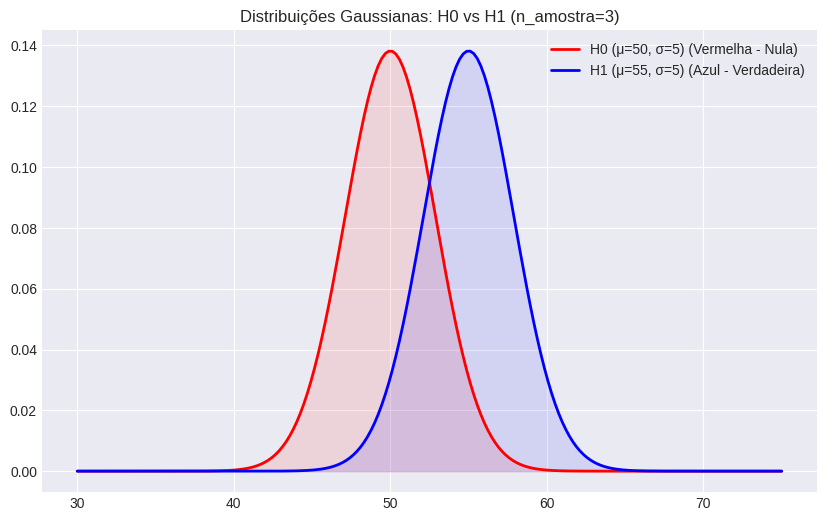

In [61]:
mu_red, sigma_red = 50, 5
mu_blue, sigma_blue = 55, 5

n_amostra = 3
n_simulacoes = 100

std_erro = sigma_red / np.sqrt(n_amostra)

x = np.linspace(mu_red - 20, mu_blue + 20, 200)
y_red = norm.pdf(x, mu_red, std_erro)
y_blue = norm.pdf(x, mu_blue, std_erro)

plt.figure(figsize=(10, 6))
plt.plot(x, y_red, color='red', label=f'H0 (μ={mu_red}, σ={sigma_red}) (Vermelha - Nula)', linewidth=2)
plt.plot(x, y_blue, color='blue', label=f'H1 (μ={mu_blue}, σ={sigma_blue}) (Azul - Verdadeira)', linewidth=2)
plt.fill_between(x, y_red, alpha=0.1, color='red')
plt.fill_between(x, y_blue, alpha=0.1, color='blue')
plt.title(f'Distribuições Gaussianas: H0 vs H1 ({n_amostra=})')
plt.legend()
plt.show()

**Simulações e falso negativo**

In [64]:
falsos_negativos = 0
p_values = []

amostras_h1_valores = norm.rvs(loc=mu_blue, scale=sigma_blue, size=(n_simulacoes, n_amostra))

for amostra in amostras_h1_valores:
  media_amostra = np.mean(amostra)
  Z_score = (media_amostra - mu_red) / std_erro
  p_value = 1 - norm.cdf(Z_score)
  p_values.append(p_value)
  if p_value > 0.05:
    falsos_negativos += 1

**Taxa final**

Total de simulações: 100
Falsos Negativos (P-value > 0.05): 56
Taxa de Falsos Negativos: 56.00%


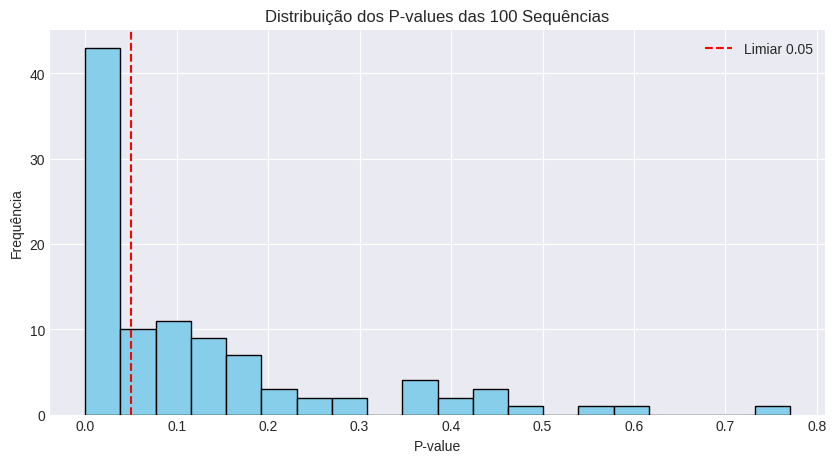

In [65]:
taxa_fn = (falsos_negativos / n_simulacoes) * 100

print(f"Total de simulações: {n_simulacoes}")
print(f"Falsos Negativos (P-value > 0.05): {falsos_negativos}")
print(f"Taxa de Falsos Negativos: {taxa_fn:.2f}%")

plt.figure(figsize=(10, 5))
plt.hist(p_values, bins=20, color='skyblue', edgecolor='black')
plt.axvline(0.05, color='red', linestyle='--', label='Limiar 0.05')
plt.title('Distribuição dos P-values das 100 Sequências')
plt.xlabel('P-value')
plt.ylabel('Frequência')
plt.legend()
plt.show()